In [2]:
# Load useful packages

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from datetime import datetime
import numpy as np
import pyproj
from dask.diagnostics import ProgressBar
import matplotlib.dates as mdate
import intake

In [3]:
# Import SIC observations
ds = xr.open_mfdataset("SICdata/AMSR*.nc", combine='by_coords')

In [5]:
# open cmip6 online catalogue
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)


In [7]:
cat = col.search(source_id=['UKESM1-0-LL'], 
                 experiment_id=['historical','piControl'], table_id=['SImon','Ofx'], 
                 variable_id=['siconc','areacello']) 
                 #member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/piContr...,NaN,20190705
1,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200309
2,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200309
3,CMIP,MOHC,UKESM1-0-LL,historical,r4i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200309
4,CMIP,MOHC,UKESM1-0-LL,historical,r7i1p1f3,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200310
5,CMIP,MOHC,UKESM1-0-LL,historical,r8i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200310
6,CMIP,MOHC,UKESM1-0-LL,historical,r5i1p1f3,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200310
7,CMIP,MOHC,UKESM1-0-LL,historical,r9i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200310
8,CMIP,MOHC,UKESM1-0-LL,historical,r6i1p1f3,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200310
9,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20200319


In [8]:
# Create dictionary from the list of datasets we found
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [10]:
dset_dict.keys()

dict_keys(['CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn', 'CMIP.NIMS-KMA.UKESM1-0-LL.historical.SImon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.SImon.gn', 'CMIP.MOHC.UKESM1-0-LL.piControl.SImon.gn'])

In [11]:
areacello = dset_dict[list(dset_dict.keys())[0]].isel(member_id = 0).squeeze()
ukesm_si = dset_dict[list(dset_dict.keys())[1]]

In [13]:
ukesm_si 

<xarray.Dataset>
Dimensions:             (i: 360, j: 330, member_id: 1, time: 1980, bnds: 2,
                         vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    type                |S7 ...
  * member_id           (member_id) <U9 'r13i1p1f2'
Dimensions without coordinates: bnds, vertices
Data variables:
    siconc              (member_id, time, j, i) float32 dask.array<chunksize=(1, 677, 330, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
Attributes: (12/52)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.4.0
    ...                      ...
    variable_name:           siconc
    variant_label:           r13i1p1f2
    netcdf_tracking_ids:     hdl:21.14100/cd429e3e-196f-4409-ba23-ad62de53614...
    version_id:              v20200611
    intake_esm_varname:      ['siconc']
    intake_esm_dataset_key:  CMIP.NIMS-KMA.UKESM1-0-LL.historical.SImon.gn

In [14]:
# Select region of interest from the Areacello variable
areac = areacello.areacello.where((areacello.latitude>=70) & (areacello.latitude<=85) & (areacello.longitude <= 10) & (areacello.longitude >= -10), drop = True)

In [15]:
# average over the ensembles
ukesm_si_en = ukesm_si.mean(dim = ['member_id'], keep_attrs=True)
# select area of interest: Greenland
ukesm_si_GL = ukesm_si_en.where((ukesm_si_en.longitude>=-10) & (ukesm_si_en.longitude<=10) & (ukesm_si_en.latitude <=85 ) & (ukesm_si_en.latitude >= 70),drop = True)

In [16]:
ukesm_iceExtent = (xr.where(ukesm_si_GL['siconc']>15, 1.,0)*areac).sum(dim=['i','j'])

In [17]:
ukesm_iceExtent

<xarray.DataArray (time: 1980)>
dask.array<sum-aggregate, shape=(1980,), dtype=float64, chunksize=(677,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
    type       |S7 b'sea_ice'
    member_id  <U8 'r1i1p1f2'

In [18]:
ukesm_iceExt_monthly = ukesm_iceExtent.groupby('time.month').mean().compute()

In [20]:
areac

<xarray.DataArray 'areacello' (j: 29, i: 18)>
dask.array<where, shape=(29, 18), dtype=float32, chunksize=(29, 18), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 267 268 269 270 271 272 273 ... 279 280 281 282 283 284
  * j          (j) int32 291 292 293 294 295 296 297 ... 314 315 316 317 318 319
    latitude   (j, i) float32 dask.array<chunksize=(29, 18), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(29, 18), meta=np.ndarray>
    member_id  <U8 'r1i1p1f2'
Attributes:
    cell_methods:   area: sum
    comment:        Horizontal area of ocean grid cells
    long_name:      Grid-Cell Area for Ocean Variables
    original_name:  mo: (variable_name: areacello)
    standard_name:  cell_area
    units:          m2

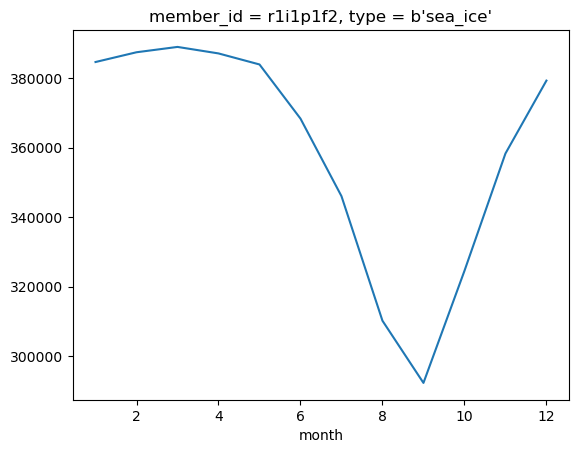

In [21]:
(ukesm_iceExt_monthly/1e6).plot()

In [22]:
# Using the Satellite data
# Output coordinates are in WGS 84 longitude and latitude
projOut = pyproj.Proj(init='epsg:4326')

# Input coordinates are in meters on the Polar Stereographic 
# projection given in the netCDF file
projIn = pyproj.Proj(init='epsg:3411',
    preserve_units=True)

xx, yy = np.meshgrid( ds.x.values, ds.y.values)
lon,lat= pyproj.transform(projIn, projOut, xx, yy )
ds['lon'] = (('y','x'),lon)
ds['lat'] = (('y','x'),lat)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_15858/4241524685.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon,lat= pyproj.

In [24]:
sat_GL = ds.where((ds.lon>=-10) & (ds.lon<=10) & (ds.lat <=85 )  & (ds.lat >= 70),drop = True)

In [26]:
area = 6.25**2
Ext = (xr.where(sat_GL.z>15, 1.,0).sum(dim=['x','y']))*area
Ext_monthly = Ext.groupby('time.month').mean().compute()

In [30]:
xr.where(sat_GL.z>15, 1.,0).sum(dim=['x','y']).values

array([4874., 5259., 5095., ..., 6072., 6110., 6161.])

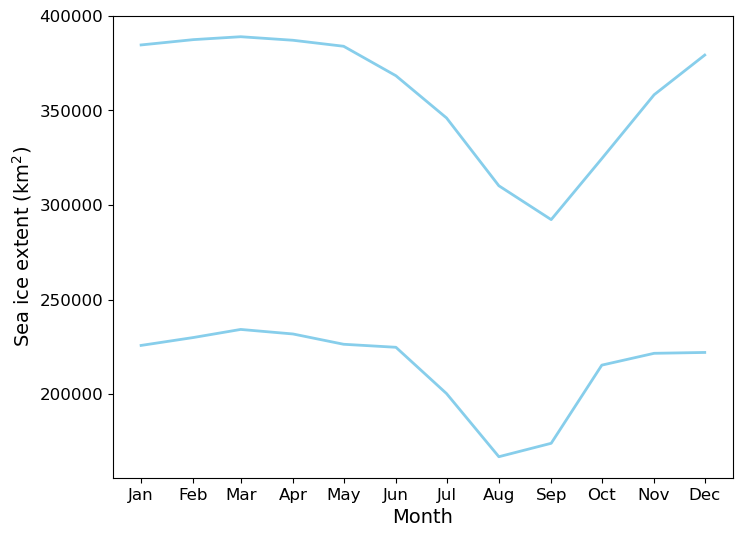

In [28]:
fig, ax = plt.subplots(figsize = (8,6))
with ProgressBar():
    ax.plot([datetime.strptime(str(m).zfill(2), '%m') for m in Ext_monthly.month.values],
            Ext_monthly,
                color='skyblue',
                lw = 2)
ax.plot([datetime.strptime(str(m).zfill(2), '%m') for m in Ext_monthly.month.values],
            ukesm_iceExt_monthly/1e6,
                color='skyblue',
                lw = 2)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel(r'Sea ice extent (km${^2})$', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
fmt = mdate.DateFormatter('%b')
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(mdate.MonthLocator())